# Initialization

## Importing libraries

As a first step we load the different libraries we are going to use, in this simple example we only need tensorflow (keras) and numpy

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization,Dropout,Flatten
from tensorflow.keras.layers import LeakyReLU,PReLU,ELU,ThresholdedReLU,ReLU
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import random
import xgboost as xgb

## Data related parameters

We define a few parameters related to the data we are going to use

In [2]:
# Parameters of the model 
num_classes = 10 # number of output class (1-9)
input_shape = (28, 28, 1) # shape of the input, we have 28 x 28 pixel size images of each number


## Loading Data

Next step is to actually load the MNIST database and perform some simple pre-process in order to introduce it to the neural network


In [6]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data() # we load the data from keras.datsets library

# This automatically generates the train & test set (otherwise we could have done it manually or through another library)

## Normalization ##
# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255 # images are encoded with up to 256 so to normalize from 0-1 we simply divide
x_test = x_test.astype("float32") / 255

# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


## Visualize the dataset

Let's see a few examples by eye now.

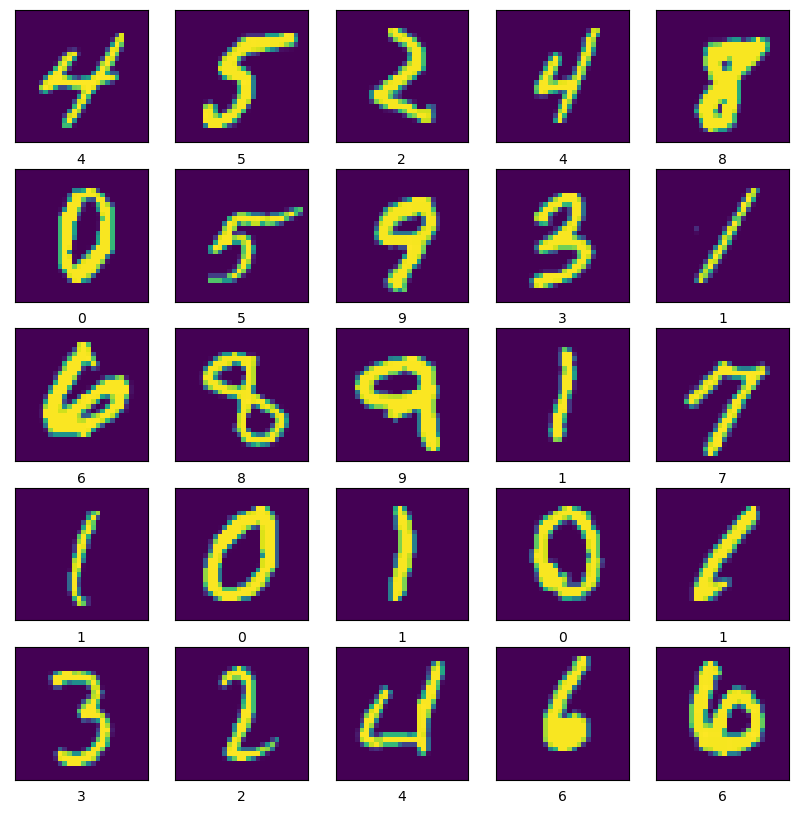

In [7]:
class_names = ['0', '1','2','3','4','5','6','7','8','9']

plt.figure(figsize=(10,10))
for i in range(25):
    random_image = random.randint(1, 60000)
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[random_image])
    plt.xlabel(class_names[y_train[random_image]])
plt.show()

## Model related parameters

Here we define hyperparameters that are going to be used in the model and training below


In [12]:
param_list = [("eta", 0.08), ("max_depth", 6), ("subsample", 0.8), ("colsample_bytree", 0.8), ("objective", "multi:softmax"), ("eval_metric", "merror"), ("alpha", 8), ("lambda", 2), ("num_class", 10)]
n_rounds = 100
early_stopping = 50

## Generating & compiling the model

Re-shape the arrays and initiate the XGboost model

In [13]:
x_train_initial = x_train
x_test_initial = x_test
x_train = x_train.reshape(x_train.shape[0],-1)
x_test = x_test.reshape(x_test.shape[0],-1)

d_train = xgb.DMatrix(x_train, label=y_train)
d_val = xgb.DMatrix(x_test, label=y_test)
eval_list = [(d_train, "train"), (d_val, "validation")]

## Example of Training proccedure


Let's now train our model for a few epochs

In [14]:
bst = xgb.train(param_list, d_train, n_rounds, evals=eval_list, early_stopping_rounds=early_stopping, verbose_eval=True)

[0]	train-merror:0.14733	validation-merror:0.15120
[1]	train-merror:0.11707	validation-merror:0.12120
[2]	train-merror:0.10358	validation-merror:0.10720
[3]	train-merror:0.09348	validation-merror:0.09570
[4]	train-merror:0.08730	validation-merror:0.09020
[5]	train-merror:0.08332	validation-merror:0.08610
[6]	train-merror:0.08135	validation-merror:0.08410
[7]	train-merror:0.07968	validation-merror:0.08170
[8]	train-merror:0.07738	validation-merror:0.08040
[9]	train-merror:0.07572	validation-merror:0.07830
[10]	train-merror:0.07342	validation-merror:0.07720
[11]	train-merror:0.07142	validation-merror:0.07540
[12]	train-merror:0.06947	validation-merror:0.07390
[13]	train-merror:0.06812	validation-merror:0.07300
[14]	train-merror:0.06725	validation-merror:0.07170
[15]	train-merror:0.06602	validation-merror:0.07020
[16]	train-merror:0.06442	validation-merror:0.07000
[17]	train-merror:0.06332	validation-merror:0.06910
[18]	train-merror:0.06205	validation-merror:0.06790
[19]	train-merror:0.06

## Evaluation

To evulate our model we need to see how well it performs to unknown data (test set):

In [15]:
d_test = xgb.DMatrix(data=x_test)
y_pred = bst.predict(d_test)

In [16]:
cr = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(cr)

[[ 966    0    0    0    0    2    5    1    6    0]
 [   1 1119    2    2    0    1    3    1    6    0]
 [   7    0  984   10    8    0    4   10    8    1]
 [   1    1    7  975    0    6    1    9    7    3]
 [   1    0    2    0  941    0    6    2    5   25]
 [   4    3    1    9    0  849    9    4   10    3]
 [   6    3    0    0    6    4  933    0    6    0]
 [   1    7   26    4    1    0    0  970    5   14]
 [   6    1    5    6    5    5    4    4  924   14]
 [   7    5    2    6   11    5    0    6    6  961]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.96      0.95      0.95      1032
           3       0.96      0.97      0.96      1010
           4       0.97      0.96      0.96       982
           5       0.97      0.95      0.96       892
           6       0.97      0.97      0.97       958
           7       0.96      0.94   

TypeError: Invalid shape (784,) for image data

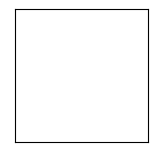

In [17]:
fig = plt.figure(figsize=(10,10))
for i in range(25):
    random_image = random.randint(1, 10000)
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test_initial[random_image])
    if class_names[int(y_test_initial[random_image])] ==class_names[int(y_pred[random_image])]:
        plt.xlabel(str(y_test_initial[random_image]) + " | " + str(int(y_pred[random_image])),color='green')
    else:
        plt.xlabel(str(y_test_initial[random_image]) + " | " + str(int(y_pred[random_image])),color='red')
plt.suptitle(' test | predicted class')
fig.tight_layout(rect=[0, 0.09, 1, 1])
plt.show()